### Extract glider section from LLC4320 

In [1]:
import xarray as xr
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
ds = xr.open_dataset('LLC4320_pre-SWOT_ACC_SMST_20111221.nc')

There are two tasks that need to be dealt with here: 
- LLC4320 data does not have lat-lon etc as a coordinate, instead the coordinates are simply index numbers. This means that the lon-lat-depth passed for the trajectory have to be converted to the corresponding index numbers first (which will not be integers). (This is annoying!)
- These interpolated "index numbers" will then be used to extract data on points. 

In [3]:
# Change coordinate of time to make life easier
ds = ds.assign_coords(time=np.linspace(1,24, num=24))

#### Coordinates to "index numbers"


In [4]:
# try for Z first as that 1d. 

z = ds.Z
k = ds.k

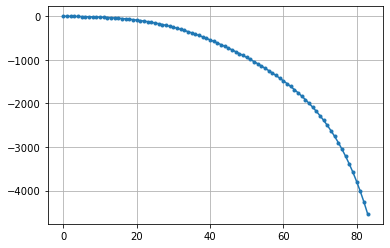

In [5]:
plt.plot(k, z, '.-')
plt.grid()

In [6]:
f_z = interpolate.interp1d(z, k, bounds_error=False)

In [7]:
X = ds.XC
Y = ds.YC

In [8]:
i = ds.i
j = ds.j

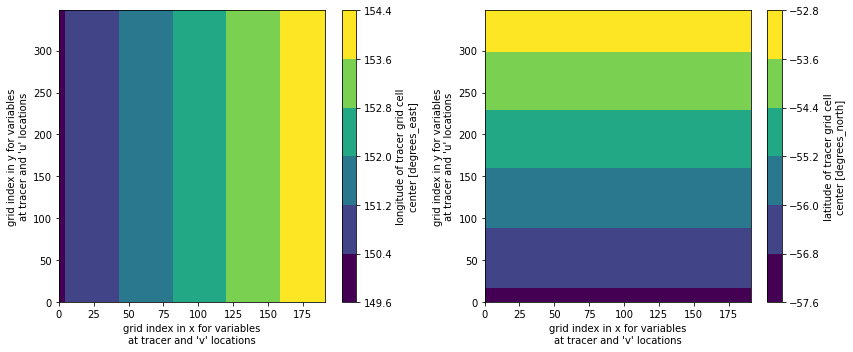

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
X.plot.contourf()

plt.subplot(122)
Y.plot.contourf()

plt.tight_layout()

It seems like (atleast for this region) the LLC grids are linear, meaning that every i value has only one X associated with. This implies that the grid is not curved relative to i and j. This makes life much easier.

In [10]:
f_x = interpolate.interp1d(X[0,:].values, i)
f_y = interpolate.interp1d(Y[:,0].values, j)

Now that we have the required functions to go from lon, lat, z to the indices i,j,k, we can move forward. 

### Interpolate to the track

In [11]:
print(X.min(), X.max())
print(Y.min(), Y.max())

<xarray.DataArray 'XC' ()>
array(150.30207825) <xarray.DataArray 'XC' ()>
array(154.28125)
<xarray.DataArray 'YC' ()>
array(-56.98995209) <xarray.DataArray 'YC' ()>
array(-53.00566864)


[Text(0, 0.5, 'lat')]

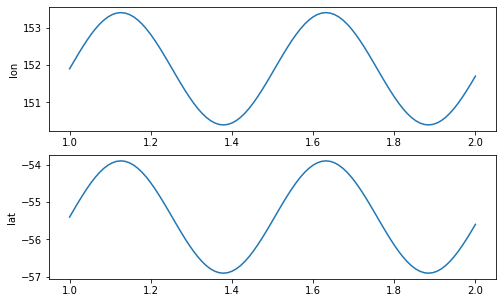

In [12]:
# 150 to 154
# -57 to -53

n = 4*ds.time.size # number of time points
ncycle = 2 # number of crossings
A = 3 # amplitude of the crossings

# create survey data
survey = xr.Dataset(
    dict(
        lon = xr.DataArray(A*(np.sin(2*np.pi*np.arange(n)/(n/ncycle))+1)/2 + 150.4,dims='points'),
        lat = xr.DataArray(A*(np.sin(2*np.pi*np.arange(n)/(n/ncycle))+1)/2 - 56.9,dims='points'),
        time = xr.DataArray(np.linspace(ds.time[0], ds.time[1], num=n),dims='points'),
    )
)

# plot survey lon and lat with time
fig,ax = plt.subplots(2,1,figsize=(8,5))
ax[0].plot(survey.time,survey.lon)
ax[1].plot(survey.time,survey.lat)
ax[0].set(ylabel='lon')
ax[1].set(ylabel='lat')


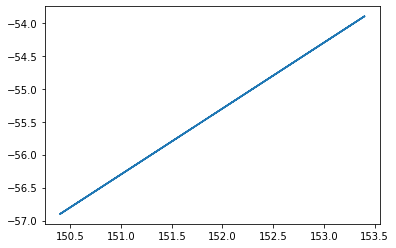

In [13]:
plt.plot(survey.lon, survey.lat)

In [14]:
survey_indices= xr.Dataset(
    dict(
        i = xr.DataArray(f_x(survey.lon), dims='points'),
        j = xr.DataArray(f_y(survey.lat), dims='points'),
        k = xr.DataArray(0*np.zeros_like(survey.lon.data), dims='points'),
        time = xr.DataArray(np.linspace(ds.time[0], ds.time[1], num=n),dims='points'),
    )
)

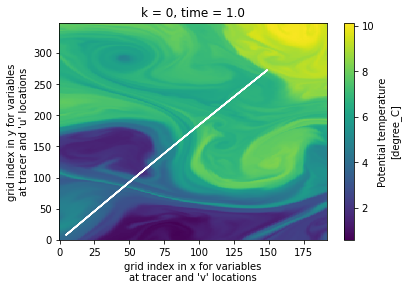

In [15]:
ds.Theta.isel(k=0, time=0).plot()
plt.plot(survey_indices.i, survey_indices.j, color='w')

In [16]:
theta_points = ds.Theta.interp(survey_indices)

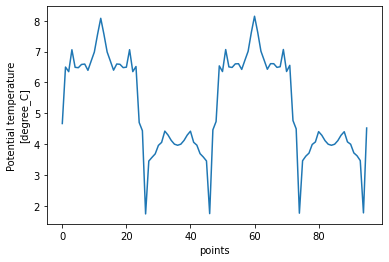

In [17]:
theta_points.plot()

#### Get glider track

In [18]:
import os

In [19]:
data_folder = '../EC2021/submission/data'

In [20]:
ds_CTD_659 = xr.load_dataset(os.path.join(data_folder ,
                                          'sg659', 'CTD_659.nc'))


FileNotFoundError: [Errno 2] No such file or directory: b'/home/jovyan/EC2021/submission/data/sg659/CTD_659.nc'

In [21]:
## Transpose

# Lat
model_boundary_n = ds.YC.max()
model_boundary_s = ds.YC.min()

shifted_lat = (ds_CTD_659.latitude - ds_CTD_659.latitude.min()
              )/(ds_CTD_659.latitude.max() - ds_CTD_659.latitude.min()
                )*(model_boundary_n-model_boundary_s)+ model_boundary_s


# Lon
model_boundary_w = ds.XC.min()
model_boundary_e = ds.XC.max()
shifted_lon = (ds_CTD_659.longitude - ds_CTD_659.longitude.min()
              )/(ds_CTD_659.longitude.max() - ds_CTD_659.longitude.min()
                )*(model_boundary_e-model_boundary_w)+ model_boundary_w



NameError: name 'ds_CTD_659' is not defined

In [169]:

depth = -ds_CTD_659.pressure.where(~np.isnan(ds_CTD_659.pressure), drop=True)
n = len(depth)


survey_track = xr.Dataset(
    dict(
        i = xr.DataArray(f_x(shifted_lon.where(~np.isnan(ds_CTD_659.pressure), drop=True)), dims='points'),
        j = xr.DataArray(f_y(shifted_lat.where(~np.isnan(ds_CTD_659.pressure), drop=True)), dims='points'),
        k = xr.DataArray(f_z(depth), dims='points'),
        time = xr.DataArray(np.linspace(ds.time[0], ds.time[1], num=n),dims='points'),
    )
)

In [175]:
model_points = ds.Theta.interp(survey_track)

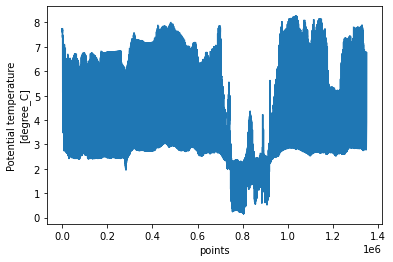

In [181]:
model_points.plot()

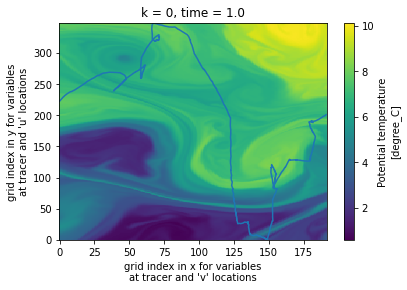

In [156]:
ds.Theta.isel(k=0, time=0).plot()

plt.plot(f_x(shifted_lon), f_y(shifted_lat))

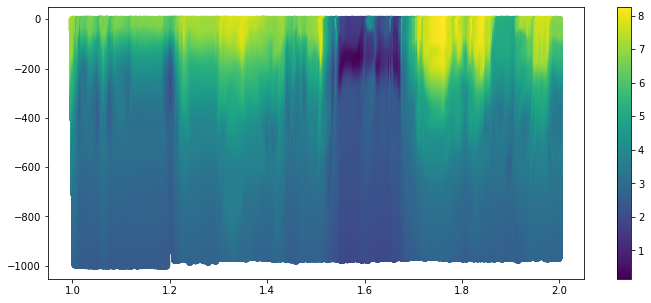

In [182]:
plt.figure(figsize=(12, 5))
plt.scatter(survey_track.time, depth, c=model_points)
plt.colorbar()

# Interpolate to trajectory created with "make_trajectory.ipynb"

In [22]:
# parameters defining the survey trajectory 
REGION = 'ACC_SMST'  # Pre-SWOT llc4320 dataset name
SAMPLING_TYPE = 'glider' # uctd or glider ... could add others
PATTERN = 'lawnmower' # back-forth or lawnmower ... could add others

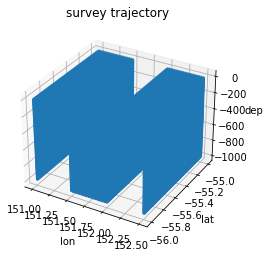

In [24]:
# load survey made with make_trajectory.ipynb
survey = xr.open_dataset('survey_trajectory_' + REGION + '_' + SAMPLING_TYPE + '_' + PATTERN + '.nc')
survey
# make sure depths are negative
survey = survey.assign(dep = -1*np.abs(survey.dep))
n = len(survey.lon.values)

# plot:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(survey.lon.values, survey.lat.values, survey.dep.values, marker='.')
ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_zlabel('dep')
ax.set_title('survey trajectory')
plt.show()

In [27]:
survey_track= xr.Dataset(
    dict(
        i = xr.DataArray(f_x(survey.lon), dims='points'),
        j = xr.DataArray(f_y(survey.lat), dims='points'),
        k = xr.DataArray(f_z(survey.dep), dims='points'),
        time = xr.DataArray(np.linspace(ds.time[0], ds.time[1], num=n),dims='points'),
    )
)

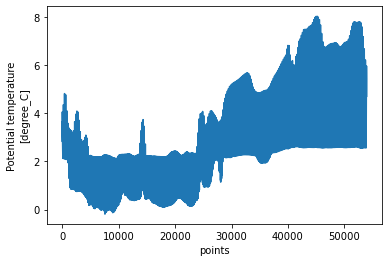

In [29]:
# interpolate
model_points = ds.Theta.interp(survey_track)
model_points.plot()

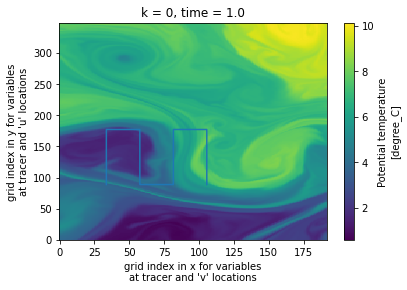

In [30]:
ds.Theta.isel(k=0, time=0).plot()
plt.plot(f_x(survey.lon), f_y(survey.lat))


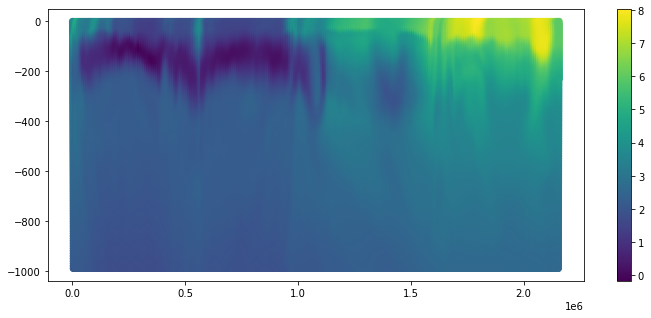

In [33]:
plt.figure(figsize=(12, 5))
plt.scatter(survey.time, survey.dep, c=model_points)
plt.colorbar()